<a href="https://colab.research.google.com/github/hsebasa/SeriesHW/blob/main/GroHW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# I know git is not the best place to store data, but this time, since
# the data is public and small, I decided to store it in github, so the
# repository is self-contained.
# This creates a folder called data, with all the CSV files that we were given
# for the analysis.
!git init
!git remote add origin https://github.com/hsebasa/SeriesHW.git
!git fetch --all
!git checkout origin/main data

Initialized empty Git repository in /content/.git/
Fetching origin
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 24 (delta 7), reused 9 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), done.
From https://github.com/hsebasa/SeriesHW
 * [new branch]      main       -> origin/main


In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
dates_format = '%Y-%m-%d'

def convert_dates_df(df, cols):
  for col in cols:
    df[col] = pd.to_datetime(df[col], format=dates_format).dt.tz_localize(None)
  return df

In [4]:
info_start_date = pd.Timestamp('2014-01-01')
info_end_date = pd.Timestamp('2022-03-13')

prod_start_date = pd.Timestamp('2015-01-01')
prod_end_date = pd.Timestamp('2020-12-01')

test_start_date = pd.Timestamp('2021-01-01')
test_end_date = pd.Timestamp('2021-12-01')

regions_ids = {93, 94, 95, 97, 98, 99, 102, 103, 104, 105}

In [5]:
def check_regions(df, col_reg='region_id'):
  regions = set(df.groupby(col_reg).groups.keys())
  assert regions == regions_ids

In [6]:
def month_diff(s, start_date=info_start_date):
  return 12 * (s.dt.year - start_date.year) + (s.dt.month - start_date.month)

In [7]:
def days_diff(s, start_date=info_start_date):
  return (s - start_date).dt.days

In [8]:
def normalize_minmax(s):
  return (s-s.min())/(s.max()-s.min())

def normalize_trunc(s):
  return (s-s.min())/s.std()
  
def normalize_norm(s):
  return (s-s.mean())/s.std()

In [9]:
def check_number_days(df, col_days='days'):
  """
  This function checks that the number of days for each region is the same, i.e.
  there are no missing days.
  """
  total_days = (info_end_date-info_start_date).days + 1
  days_per_region = df.groupby('region_id')[col_days].nunique()
  if (days_per_region != total_days).any():
    warnings.warn('some regions have a different number of days')

In [10]:
def check_number_months(df, col_months='months', 
                        start_date=info_start_date, end_date=info_end_date):
  """
  This function checks that the number of months given for each region 
  is the same, i.e. there are no missing months.
  """
  years = (end_date.year-start_date.year)
  total_months = 12*years + (end_date.month-start_date.month)+1
  months_per_region = df.groupby('region_id')[col_months].nunique()
  
  assert not (months_per_region != total_months).any(), 'some regions have a different number of months'

In [11]:
def summarize_month(df, col_name):
  def quant(q):
    return lambda x: x.quantile(q)
  def quant_diff(q1, q2):
    return lambda x: x.quantile(q2)-x.quantile(q1)

  groups = df.groupby(['region_id', 'months'])
  res = groups[col_name].agg(q1=quant(0.25), q2=quant(0.5), 
                             q3=quant(0.75), q4=quant(0.9),
                             d1=quant_diff(0.25, 0.75),
                             mx='max', mn='min', avg='mean')
  return res

In [12]:
def inpute(df, radius=1):
  """
  https://stackoverflow.com/questions/57393103/pandas-replace-nans-with-mean-of-n-nearest-non-empty-values-in-column
  """
  a = df.rolling(radius).mean()
  b = df.iloc[::-1].rolling(radius).mean()

  c = a.fillna(b).fillna(df).interpolate(method='nearest').ffill().bfill()
  df = df.fillna(c)
  return df

# Preprocess

## Precipitation

In [13]:
raw_precipitation = pd.read_csv("data/Daily Precipitation.csv")
convert_dates_df(raw_precipitation, ('start_date', 'end_date'))
raw_precipitation.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
precip               float64
region_id              int64
dtype: object

In [14]:
raw_precipitation.isnull().any()

start_date    False
end_date      False
precip        False
region_id     False
dtype: bool

In [15]:
check_regions(raw_precipitation)

In [16]:
raw_precipitation['days'] = days_diff(raw_precipitation['end_date'])
raw_precipitation['months'] = month_diff(raw_precipitation['end_date'])

In [17]:
check_number_days(raw_precipitation, col_days='days')
check_number_months(raw_precipitation, col_months='months')

In [18]:
raw_precipitation['precip'].describe()

count    29940.000000
mean         7.275856
std          9.468009
min          0.000000
25%          1.112265
50%          4.340616
75%         10.086396
max        151.307444
Name: precip, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b195121d0>]],
      dtype=object)

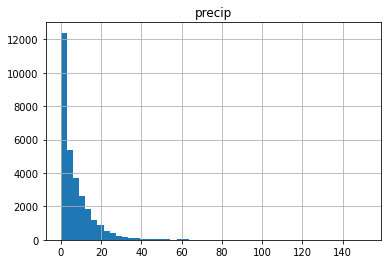

In [19]:
raw_precipitation.hist('precip', bins=50)

In [20]:
raw_precipitation['precip_mod'] = normalize_trunc(raw_precipitation['precip'])

In [21]:
precipitation = summarize_month(raw_precipitation, col_name='precip_mod')
precipitation

q1        q2        q3        q4        d1         mx  \
region_id months                                                                
93        0       0.001790  0.015184  0.054487  0.678576  0.052697   3.466796   
          1       0.000606  0.004286  0.013498  0.101471  0.012893   0.397929   
          2       0.000791  0.027224  0.567057  2.060341  0.566265   7.100018   
          3       0.683134  1.049794  1.393519  2.065683  0.710384   3.185755   
          4       0.395862  0.723557  1.296233  2.210631  0.900370   3.092338   
...                    ...       ...       ...       ...       ...        ...   
105       94      0.569809  1.200769  2.619505  3.609618  2.049696   6.288127   
          95      0.028551  0.180851  2.018945  5.064177  1.990395   7.721921   
          96      0.006563  0.011049  0.020848  0.115120  0.014284   0.336838   
          97      0.098115  0.609065  3.455432  8.995157  3.357317  15.980915   
          98      0.009739  0.224382  0.287254  1.534043  0.277516   2.746789   

                        mn       avg  
region_id months                      
93        0       0.000040  0.268457  
          1       0.000025  0.034433  
          2       0.000007  0.655733  
          3       0.051613  1.101957  
          4       0.143641  0.967546  
...                    ...       ...  
105       94      0.086747  1.695945  
          95      0.000033  1.529348  
          96      0.000544  0.043608  
          97      0.010405  2.839470  
          98      0.002234  0.494197  

[990 rows x 8 columns]

## Soil Moisture

In [22]:
raw_moisture = pd.read_csv("data/Daily Soil Mositure.csv")
convert_dates_df(raw_moisture, ('start_date', 'end_date'))
raw_moisture.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
smos                 float64
region_id              int64
dtype: object

In [23]:
raw_moisture.isnull().any()

start_date    False
end_date      False
smos          False
region_id     False
dtype: bool

In [24]:
check_regions(raw_moisture)

In [25]:
raw_moisture['days'] = days_diff(raw_moisture['end_date'])
raw_moisture['months'] = month_diff(raw_moisture['end_date'])

In [26]:
check_number_days(raw_moisture, col_days='days')
check_number_months(raw_moisture, col_months='months')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: some regions have a different number of days
  if __name__ == '__main__':


In [27]:
raw_moisture['smos'].describe()

count    29603.000000
mean         0.266492
std          0.092495
min          0.004318
25%          0.203135
50%          0.260049
75%          0.321686
max          0.814535
Name: smos, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b18e4f2d0>]],
      dtype=object)

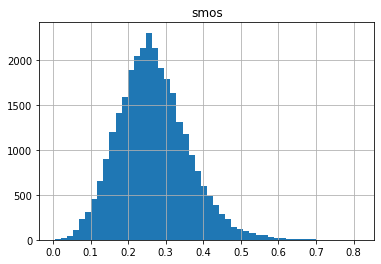

In [28]:
raw_moisture.hist('smos', bins=50)

In [29]:
raw_moisture['smos_mod'] = normalize_trunc(raw_moisture['smos'])

In [30]:
moisture = summarize_month(raw_moisture, col_name='smos_mod')
moisture

q1        q2        q3        q4        d1        mx  \
region_id months                                                               
93        0       2.489719  3.071580  3.353687  4.052136  0.863968  4.809357   
          1       2.510807  2.939144  3.177882  3.729588  0.667075  4.041195   
          2       2.073835  2.726214  3.225006  3.898020  1.151171  4.036038   
          3       2.580308  2.949137  3.529644  3.714432  0.949336  4.966163   
          4       2.279184  2.649666  3.001700  3.528059  0.722516  3.625854   
...                    ...       ...       ...       ...       ...       ...   
105       94      4.031834  4.225898  4.339424  4.789530  0.307591  6.477209   
          95      4.266989  4.650765  4.847240  5.445253  0.580251  5.615409   
          96      4.059170  4.528208  4.875800  5.333497  0.816630  5.415463   
          97      4.374657  4.902742  5.480834  5.649711  1.106177  5.756363   
          98      4.480986  4.738722  4.738722  5.247543  0.257735  5.756363   

                        mn       avg  
region_id months                      
93        0       1.908876  3.065612  
          1       1.811537  2.904615  
          2       1.609224  2.706107  
          3       1.405275  2.958206  
          4       1.320344  2.531482  
...                    ...       ...  
105       94      3.028356  4.253488  
          95      3.548082  4.618796  
          96      3.216714  4.491754  
          97      4.068222  4.899098  
          98      4.395075  4.793780  

[990 rows x 8 columns]

## Temperature

In [31]:
raw_temperature = pd.read_csv("data/Daily Temperature.csv")
convert_dates_df(raw_temperature, ('start_date', 'end_date'))
raw_temperature.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
temp                 float64
region_id              int64
dtype: object

In [32]:
raw_temperature.isnull().any()

start_date    False
end_date      False
temp          False
region_id     False
dtype: bool

In [33]:
check_regions(raw_temperature)

In [34]:
raw_temperature['days'] = days_diff(raw_temperature['end_date'])
raw_temperature['months'] = month_diff(raw_temperature['end_date'])

In [35]:
check_number_days(raw_temperature, col_days='days')
check_number_months(raw_temperature, col_months='months')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: some regions have a different number of days
  if __name__ == '__main__':


In [36]:
raw_temperature['temp'].describe()

count    12930.000000
mean        26.542191
std          2.494511
min         17.031505
25%         24.843353
50%         26.591613
75%         28.185999
max         37.295265
Name: temp, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b18d1ad50>]],
      dtype=object)

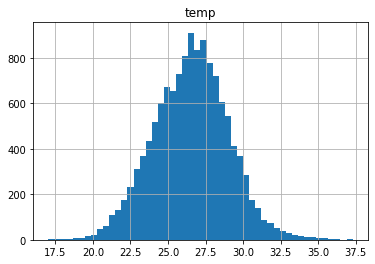

In [37]:
raw_temperature.hist('temp', bins=50)

In [38]:
raw_temperature['temp_mod'] = normalize_norm(raw_temperature['temp'])

In [39]:
temperature = summarize_month(raw_temperature, col_name='temp_mod')
temperature

q1        q2        q3        q4        d1        mx  \
region_id months                                                               
93        0      -0.946967 -0.797890  0.016015  0.536725  0.962982  1.465003   
          1      -0.275011 -0.083892  0.730455  0.992489  1.005466  1.295286   
          2       0.629110  1.568792  1.727607  2.176111  1.098497  2.873767   
          3      -0.758691  0.137846  0.386069  0.800249  1.144760  0.890482   
          4      -0.342178 -0.035840  0.312780  0.867670  0.654958  1.302526   
...                    ...       ...       ...       ...       ...       ...   
105       94     -0.587641 -0.449841 -0.158974  0.100345  0.428667  0.227783   
          95     -1.030390 -0.445485 -0.194331 -0.104684  0.836059 -0.093228   
          96     -1.051037 -0.633447 -0.258504  0.294235  0.792533  0.705863   
          97     -0.044954  0.256677  0.322673  0.361022  0.367627  0.386587   
          98     -0.206361 -0.181748  0.226907  0.734323  0.433267  1.072600   

                        mn       avg  
region_id months                      
93        0      -1.158150 -0.424946  
          1      -1.805094  0.042331  
          2      -1.144758  1.137256  
          3      -1.856950 -0.109978  
          4      -0.814847  0.040320  
...                    ...       ...  
105       94     -1.705992 -0.488754  
          95     -1.732038 -0.675368  
          96     -2.369690 -0.610303  
          97     -0.470610  0.090075  
          98     -0.857730  0.010733  

[990 rows x 8 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b18d0ccd0>],
      dtype=object)

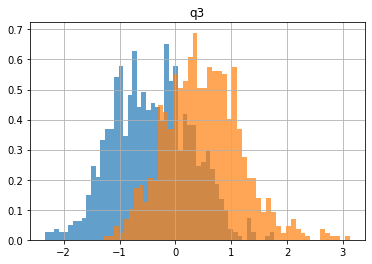

In [40]:
ax = plt.gca()
temperature.hist('q1', bins=50, ax=ax, density=True, alpha=0.7)
temperature.hist('q3', bins=50, ax=ax, density=True, alpha=0.7)

## NDVI

In [41]:
raw_ndvi = pd.read_csv("data/Eight Day NDVI.csv")
convert_dates_df(raw_ndvi, ('start_date', 'end_date'))
raw_ndvi.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
ndvi                 float64
region_id              int64
dtype: object

In [42]:
raw_ndvi.isnull().any()

start_date    False
end_date      False
ndvi          False
region_id     False
dtype: bool

In [43]:
check_regions(raw_ndvi)

In [44]:
raw_ndvi['days'] = days_diff(raw_ndvi['end_date'])
raw_ndvi['months'] = month_diff(raw_ndvi['end_date'])

In [45]:
months = set(range(99))
missing_months_per_region = raw_ndvi.groupby(['region_id']).apply(lambda df: months-set(df['months'].to_list()))
missing_months_per_region

region_id
93             {34}
94               {}
95               {}
97             {34}
98             {34}
99               {}
102              {}
103              {}
104    {34, 83, 94}
105        {48, 34}
dtype: object

In [46]:
raw_ndvi['ndvi'].describe()

count    3338.000000
mean        0.798429
std         0.033146
min         0.573141
25%         0.784141
50%         0.805861
75%         0.821163
max         0.862471
Name: ndvi, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2b18b7ffd0>]],
      dtype=object)

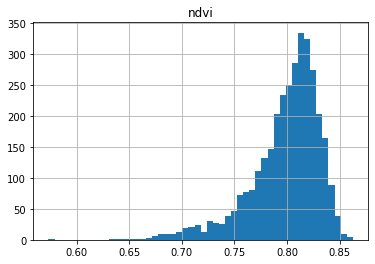

In [47]:
raw_ndvi.hist('ndvi', bins=50)

In [48]:
raw_ndvi['ndvi_mod'] = normalize_norm(raw_ndvi['ndvi'])

In [49]:
mean_ndvi = raw_ndvi.groupby(['region_id', 'months'])['ndvi'].mean()
ndvi_stacked = inpute(mean_ndvi.unstack(level=1))

In [50]:
ndvi = ndvi_stacked.stack(level=0).to_frame('avg')
ndvi

avg
region_id months          
93        0       0.718269
          1       0.767647
          2       0.743301
          3       0.807792
          4       0.813410
...                    ...
105       94      0.798444
          95      0.811967
          96      0.804896
          97      0.790585
          98      0.795875

[990 rows x 1 columns]

## Production quantity

In [51]:
raw_prod = pd.read_csv("data/Production Quantity.csv")
convert_dates_df(raw_prod, ('start_date', 'end_date'))
raw_prod.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
prod                   int64
region_id              int64
dtype: object

In [52]:
raw_prod.isnull().any()

start_date    False
end_date      False
prod          False
region_id     False
dtype: bool

In [53]:
check_regions(raw_prod)

In [54]:
raw_prod['months'] = month_diff(raw_prod['end_date'], start_date=info_start_date)

In [55]:
check_number_months(raw_prod, start_date=prod_start_date, end_date=prod_end_date)

In [56]:
raw_prod['prod'].describe()

count       720.000000
mean     159014.201389
std      142882.722751
min       10215.000000
25%       35445.500000
50%       91945.500000
75%      269946.000000
max      593579.000000
Name: prod, dtype: float64

In [57]:
def normalize_prod(df):
  groups = df.groupby('region_id')['prod']
  mean = groups.mean().to_dict()
  std = groups.std().to_dict()
  prod_norm = df[['region_id', 'prod']].apply(lambda x: (x['prod']-mean[x['region_id']])/std[x['region_id']], axis=1)

  params = {'mean': mean, 'std': std}
  return params, prod_norm

def rescale_prod(df, params, col_prod_norm='prod_norm'):
  mean = params['mean']
  std = params['std']

  prod = df[['region_id', col_prod_norm]].apply(lambda x: x[col_prod_norm]*std[x['region_id']]+mean[x['region_id']], axis=1)
  return prod

prod_norm_param, raw_prod['prod_norm'] = normalize_prod(raw_prod)

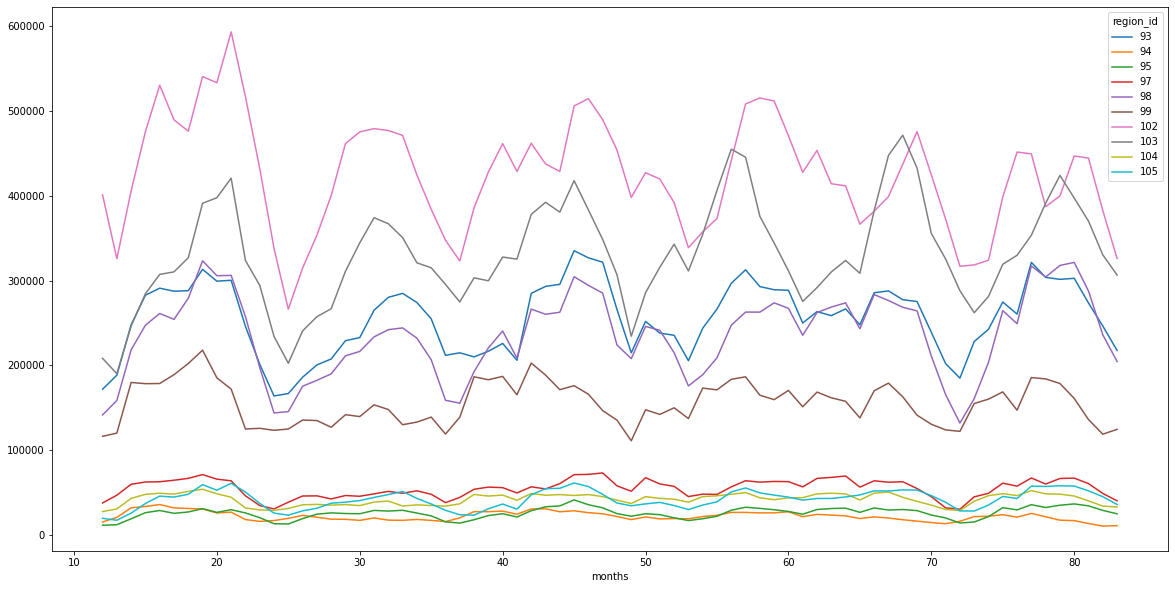

In [58]:
prod_ns = raw_prod.groupby(['region_id', 'months'])['prod'].mean().to_frame('avg')
prod_ns_stacked = prod_ns.unstack(level=0)
prod_ns_stacked['avg'].plot(figsize=(20, 10))

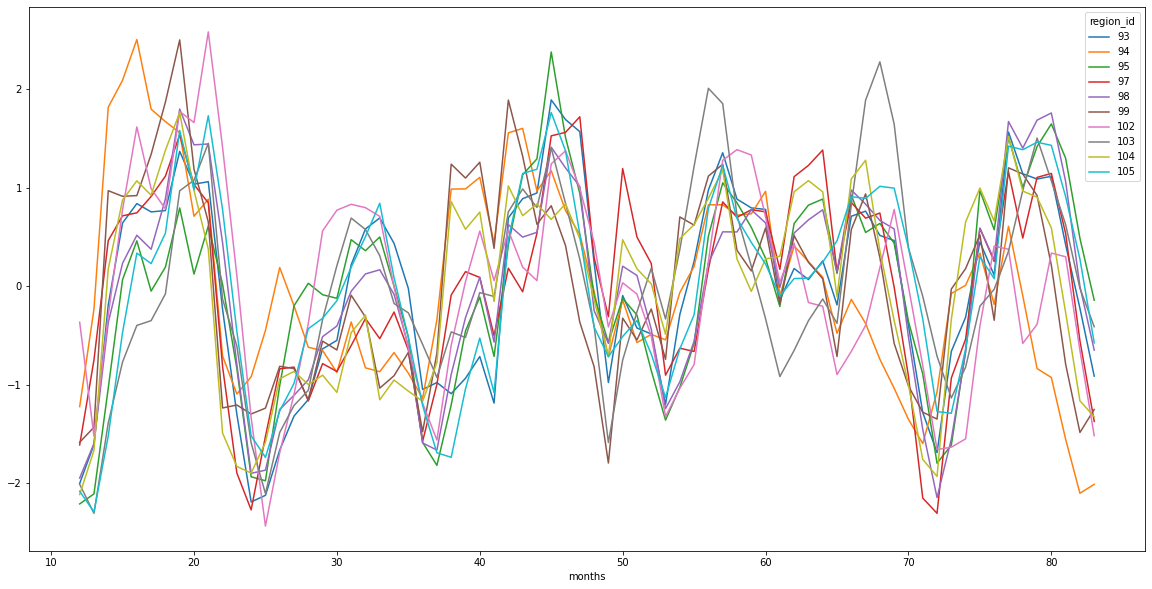

In [59]:
prod = raw_prod.groupby(['region_id', 'months'])['prod_norm'].mean().to_frame('avg')
prod_stacked = prod.unstack(level=0)
prod_stacked['avg'].plot(figsize=(20, 10))

## Predicted production

In [60]:
raw_pred_prod = pd.read_csv("data/predicted_production_qty.csv")
nomod_pred_prod = raw_pred_prod.copy()
convert_dates_df(raw_pred_prod, ('start_date', 'end_date'))
raw_pred_prod.dtypes

start_date    datetime64[ns]
end_date      datetime64[ns]
prod                 float64
region_id              int64
dtype: object

In [61]:
raw_pred_prod.isnull().any()

start_date    False
end_date      False
prod           True
region_id     False
dtype: bool

In [62]:
check_regions(raw_pred_prod)

In [63]:
raw_pred_prod['months'] = month_diff(raw_pred_prod['end_date'], start_date=info_start_date)

In [64]:
check_number_months(raw_pred_prod, start_date=test_start_date, end_date=test_end_date)

In [65]:
pred_prod = raw_pred_prod.groupby(['region_id', 'months'])['prod'].mean().to_frame('avg')
pred_prod

avg
region_id months     
93        84      NaN
          85      NaN
          86      NaN
          87      NaN
          88      NaN
...               ...
105       91      NaN
          92      NaN
          93      NaN
          94      NaN
          95      NaN

[120 rows x 1 columns]

In [66]:
months_pred_prod = set(raw_pred_prod.months)
months_pred_prod

{84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95}

## Merge Data

In [67]:
precipitation_rn = precipitation.rename(columns={col: col+'_p' for col in precipitation.columns})
moisture_rn = moisture.rename(columns={col: col+'_m' for col in moisture.columns})
temperature_rn = temperature.rename(columns={col: col+'_t' for col in temperature.columns})
ndvi_rn = ndvi.rename(columns={col: col+'_n' for col in ndvi.columns})
prod_rn = prod.rename(columns={col: col+'_o' for col in ndvi.columns})

data_chars = precipitation_rn.copy()
for df in [moisture_rn, temperature_rn, ndvi_rn]:
  data_chars = data_chars.merge(df, left_index=True, right_index=True, how='outer')
  print(data_chars.isnull().any().any())
data_chars

False
False
False


q1_p      q2_p      q3_p      q4_p      d1_p       mx_p  \
region_id months                                                                
93        0       0.001790  0.015184  0.054487  0.678576  0.052697   3.466796   
          1       0.000606  0.004286  0.013498  0.101471  0.012893   0.397929   
          2       0.000791  0.027224  0.567057  2.060341  0.566265   7.100018   
          3       0.683134  1.049794  1.393519  2.065683  0.710384   3.185755   
          4       0.395862  0.723557  1.296233  2.210631  0.900370   3.092338   
...                    ...       ...       ...       ...       ...        ...   
105       94      0.569809  1.200769  2.619505  3.609618  2.049696   6.288127   
          95      0.028551  0.180851  2.018945  5.064177  1.990395   7.721921   
          96      0.006563  0.011049  0.020848  0.115120  0.014284   0.336838   
          97      0.098115  0.609065  3.455432  8.995157  3.357317  15.980915   
          98      0.009739  0.224382  0.287254  1.534043  0.277516   2.746789   

                      mn_p     avg_p      q1_m      q2_m  ...     avg_m  \
region_id months                                          ...             
93        0       0.000040  0.268457  2.489719  3.071580  ...  3.065612   
          1       0.000025  0.034433  2.510807  2.939144  ...  2.904615   
          2       0.000007  0.655733  2.073835  2.726214  ...  2.706107   
          3       0.051613  1.101957  2.580308  2.949137  ...  2.958206   
          4       0.143641  0.967546  2.279184  2.649666  ...  2.531482   
...                    ...       ...       ...       ...  ...       ...   
105       94      0.086747  1.695945  4.031834  4.225898  ...  4.253488   
          95      0.000033  1.529348  4.266989  4.650765  ...  4.618796   
          96      0.000544  0.043608  4.059170  4.528208  ...  4.491754   
          97      0.010405  2.839470  4.374657  4.902742  ...  4.899098   
          98      0.002234  0.494197  4.480986  4.738722  ...  4.793780   

                      q1_t      q2_t      q3_t      q4_t      d1_t      mx_t  \
region_id months                                                               
93        0      -0.946967 -0.797890  0.016015  0.536725  0.962982  1.465003   
          1      -0.275011 -0.083892  0.730455  0.992489  1.005466  1.295286   
          2       0.629110  1.568792  1.727607  2.176111  1.098497  2.873767   
          3      -0.758691  0.137846  0.386069  0.800249  1.144760  0.890482   
          4      -0.342178 -0.035840  0.312780  0.867670  0.654958  1.302526   
...                    ...       ...       ...       ...       ...       ...   
105       94     -0.587641 -0.449841 -0.158974  0.100345  0.428667  0.227783   
          95     -1.030390 -0.445485 -0.194331 -0.104684  0.836059 -0.093228   
          96     -1.051037 -0.633447 -0.258504  0.294235  0.792533  0.705863   
          97     -0.044954  0.256677  0.322673  0.361022  0.367627  0.386587   
          98     -0.206361 -0.181748  0.226907  0.734323  0.433267  1.072600   

                      mn_t     avg_t     avg_n  
region_id months                                
93        0      -1.158150 -0.424946  0.718269  
          1      -1.805094  0.042331  0.767647  
          2      -1.144758  1.137256  0.743301  
          3      -1.856950 -0.109978  0.807792  
          4      -0.814847  0.040320  0.813410  
...                    ...       ...       ...  
105       94     -1.705992 -0.488754  0.798444  
          95     -1.732038 -0.675368  0.811967  
          96     -2.369690 -0.610303  0.804896  
          97     -0.470610  0.090075  0.790585  
          98     -0.857730  0.010733  0.795875  

[990 rows x 25 columns]

In [68]:
data_chars_nrid = data_chars.reset_index().groupby('months').mean()
data_chars_nrid = data_chars_nrid[[col for col in data_chars_nrid.columns if col != 'region_id']]
data_chars_nrid

,q1_p,q2_p,q3_p,q4_p,d1_p,mx_p,mn_p,avg_p,q1_m,q2_m,...,avg_m,q1_t,q2_t,q3_t,q4_t,d1_t,mx_t,mn_t,avg_t,avg_n
months,,,,,,,,,,,,,,,,,,,,,
0,0.016681,0.115124,0.398610,0.834761,0.381929,3.956973,0.000131,0.400798,2.492773,2.931681,...,2.979431,-1.455312,-0.969367,-0.333468,0.114992,1.121844,0.491365,-2.409903,-0.937215,0.754515
1,0.005400,0.022247,0.172533,0.454083,0.167133,1.057900,0.000222,0.150426,2.190250,2.504278,...,2.649287,-0.682648,-0.054622,0.628566,1.088380,1.311214,1.465784,-2.148739,-0.104053,0.770812
2,0.015897,0.120628,0.661508,2.067201,0.645611,6.034961,0.001235,0.684425,2.155923,2.468292,...,2.547034,-0.323310,0.612344,1.416303,1.920154,1.739613,2.466995,-1.780331,0.527902,0.753208
3,0.477022,0.793441,1.298005,2.149902,0.820983,3.943024,0.100755,1.035734,2.083748,2.444745,...,2.508427,-0.568461,0.057014,0.521695,0.951400,1.090156,1.228077,-1.675383,-0.032202,0.781399
4,0.376477,0.843172,1.513252,2.227945,1.136775,3.296558,0.055601,1.043971,2.171936,2.557896,...,2.593637,-0.963893,-0.331063,0.163701,0.520301,1.127593,0.890647,-1.946850,-0.421276,0.801500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.492683,0.891697,1.471972,2.002845,0.979289,3.368102,0.076577,1.077260,3.313700,3.731128,...,3.775396,-0.561417,-0.190962,0.160065,0.352522,0.721482,0.482450,-1.073184,-0.219738,0.815670
95,0.104316,0.335027,1.045256,2.814031,0.940940,6.096714,0.012474,0.978720,3.312599,3.756604,...,3.769930,-0.649650,-0.198766,0.138287,0.294375,0.787937,0.505127,-1.450297,-0.317102,0.813619
96,0.114161,0.289215,0.497582,0.859184,0.383421,2.685508,0.026160,0.432071,3.415197,3.862176,...,3.898360,-0.200933,0.190016,0.573741,0.813081,0.774674,1.057980,-0.977259,0.162014,0.806576


In [69]:
prod_nrid = prod_rn.reset_index().groupby('months').mean()
prod_nrid = prod_nrid[[col for col in prod_nrid.columns if col != 'region_id']]
prod_nrid

,avg_o
months,
12,-1.715863
13,-1.551783
14,-0.136675
15,0.507573
16,0.861612
...,...
79,0.887015
80,0.838543
81,0.253873


In [70]:
data_chars_nrid_train = data_chars_nrid.loc[prod_nrid.index, :]
data_chars_nrid_train

,q1_p,q2_p,q3_p,q4_p,d1_p,mx_p,mn_p,avg_p,q1_m,q2_m,...,avg_m,q1_t,q2_t,q3_t,q4_t,d1_t,mx_t,mn_t,avg_t,avg_n
months,,,,,,,,,,,,,,,,,,,,,
12,0.095549,0.223038,0.466639,0.959312,0.371089,3.019360,0.024926,0.454131,2.700916,3.107700,...,3.251373,-1.288037,-0.651383,-0.110165,0.100929,1.177872,0.421370,-2.241106,-0.750958,0.761135
13,0.043023,0.090080,0.173821,0.473349,0.130798,2.378535,0.008199,0.229872,2.385624,2.702997,...,2.748546,-0.732088,-0.111780,0.364635,0.815234,1.096723,1.150104,-1.965588,-0.192193,0.764337
14,0.069729,0.223400,0.498631,1.074712,0.428901,2.136530,0.008442,0.410420,2.053798,2.369999,...,2.425939,-0.598238,0.106040,1.024524,1.496612,1.622762,2.016012,-1.831503,0.159446,0.753840
15,0.344549,0.681981,1.177916,1.758706,0.833367,3.337498,0.048283,0.873181,2.116334,2.466372,...,2.491433,-0.686804,-0.043818,0.570674,1.070875,1.257478,1.668066,-1.689745,-0.036635,0.773039
16,0.445191,0.756478,1.346831,1.840702,0.901641,3.054371,0.135348,0.963004,2.092584,2.358883,...,2.428488,-1.030095,-0.434386,0.130311,0.645258,1.160406,0.972678,-2.298854,-0.472954,0.803977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.147831,0.391235,0.821767,1.469181,0.673936,2.811308,0.020204,0.625551,2.476312,2.816689,...,2.825276,-0.211218,0.278167,0.825113,1.103685,1.036331,1.343373,-1.324722,0.233298,0.819637
80,0.417152,0.799437,1.258097,1.807258,0.840945,2.605943,0.084474,0.910109,2.601627,2.989239,...,3.005309,-0.024208,0.297003,0.681609,0.935205,0.705817,1.166277,-0.554147,0.317574,0.815620
81,0.276377,0.575822,1.098167,1.652047,0.821790,2.603787,0.072368,0.786312,2.611822,3.095777,...,3.141666,0.044998,0.323267,0.618228,0.863278,0.573229,1.067225,-0.630783,0.278826,0.815931


In [71]:
data_chars_nrid_test = data_chars_nrid.loc[months_pred_prod, :]
data_chars_nrid_test

,q1_p,q2_p,q3_p,q4_p,d1_p,mx_p,mn_p,avg_p,q1_m,q2_m,...,avg_m,q1_t,q2_t,q3_t,q4_t,d1_t,mx_t,mn_t,avg_t,avg_n
months,,,,,,,,,,,,,,,,,,,,,
84,0.179117,0.359069,0.672226,2.556864,0.493108,7.994192,0.036543,0.957661,3.127372,3.490434,...,3.608327,-0.923073,-0.561086,-0.224439,-0.066059,0.698634,0.028481,-1.473282,-0.624981,0.811928
85,0.008149,0.069794,0.237693,0.496580,0.229544,0.930146,0.001188,0.176087,2.893834,3.273201,...,3.357368,-0.713892,0.063724,0.806129,1.334255,1.520021,1.942068,-1.671727,0.074237,0.786107
86,0.200560,0.450513,0.979277,1.910105,0.778717,6.100196,0.014659,0.884424,2.625054,2.967995,...,3.046837,-0.044441,0.533533,0.924950,1.290377,0.969391,1.661648,-0.841665,0.450501,0.779959
87,0.334334,0.644040,1.212885,1.894485,0.878551,3.153678,0.033460,0.885954,2.550147,2.866695,...,2.967923,-0.107484,0.261811,0.738739,1.042719,0.846223,1.198776,-0.994873,0.252765,0.808725
88,0.372801,0.854372,1.462194,2.156989,1.089393,4.185413,0.051238,1.061911,2.493146,2.781438,...,2.885975,-0.311455,0.142894,0.481343,0.761543,0.792798,1.030984,-1.078900,0.073005,0.823549
89,0.190612,0.438142,0.825884,1.344435,0.635272,2.312899,0.055977,0.605447,2.624069,2.908851,...,2.997677,-0.714645,-0.172915,0.326616,0.621824,1.041260,0.806347,-1.555994,-0.213173,0.823689
90,0.096520,0.307492,0.855106,1.498395,0.758586,2.601522,0.006574,0.580464,2.281485,2.573857,...,2.626888,-0.402987,0.055399,0.390179,0.736471,0.793166,0.995792,-1.319828,-0.030180,0.824471
91,0.367775,0.639720,1.148963,1.610457,0.781188,2.461526,0.068775,0.816027,2.405962,2.824869,...,2.845742,-0.380342,-0.004566,0.358686,0.745368,0.739028,1.050798,-1.197276,-0.041697,0.815383
92,0.323473,0.652789,1.199801,1.879578,0.876328,3.503639,0.071148,0.905911,2.650325,3.133310,...,3.109064,-0.316646,0.018033,0.377162,0.645832,0.693808,0.974150,-1.095213,-0.017491,0.813966


# SARIMAX model

In [72]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [73]:
endog = prod_nrid
exog = sm.add_constant(data_chars_nrid_train)

mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                           Statespace Model Results                           
Dep. Variable:                  avg_o   No. Observations:                   72
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -42.496
Date:                Wed, 06 Apr 2022   AIC                            142.992
Time:                        00:49:44   BIC                            209.015
Sample:                             0   HQIC                           169.276
                                 - 72                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.1702      5.528     -1.840      0.066     -21.006       0.665
q1_p           1.5053      2.970      0.507      0.612      -4.316       7.327
q2_p           2.1446      3.740      0.573      0.5

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [74]:
alpha_pred = 0.05
pred_train = res.get_prediction(alpha=alpha_pred).summary_frame()

In [75]:
exog_test = sm.add_constant(data_chars_nrid_test)
forecast_prod = res.get_forecast(steps=len(data_chars_nrid_test), 
                                 exog=exog_test).summary_frame(alpha=alpha_pred)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [76]:
def plot_summary_frame(months, summary_frame, ax=None, label="Predicted"):
  if not ax:
    ax = plt.gca()
  y = summary_frame['mean'].values
  y_l = summary_frame['mean_ci_lower'].values
  y_u = summary_frame['mean_ci_upper'].values
  ax.plot(months, y, label=label, color='b', linewidth=7)
  ax.fill_between(months, y_l, y_u, color='b', alpha=.1)
  plt.legend()

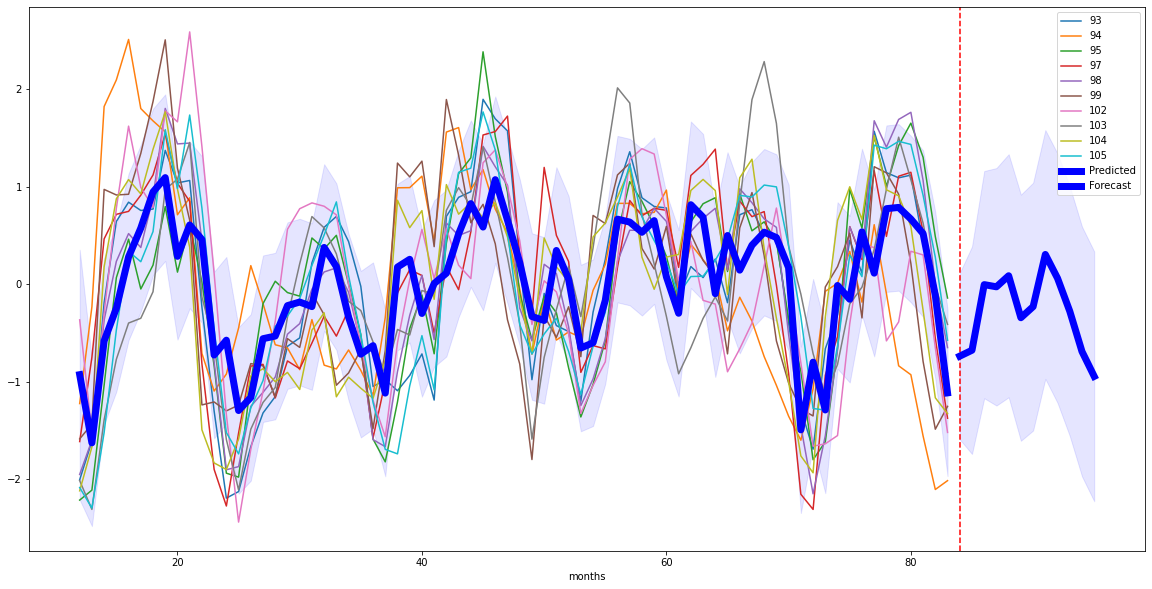

In [77]:
ax = plt.gca()
prod_stacked['avg'].plot(figsize=(20, 10), ax=ax)

plot_summary_frame(exog.index, pred_train, ax=ax)
ax.axvline(exog_test.index.min(), c='r', linestyle='--')
plot_summary_frame(exog_test.index, forecast_prod, ax=ax, label="Forecast")

In [78]:
forecast_avg = forecast_prod
forecast_avg.index = exog_test.index
forecast_avg = forecast_avg.reset_index()
forecast_avg

avg_o,months,mean,mean_se,mean_ci_lower,mean_ci_upper
0,84,-0.737014,0.434907,-1.589416,0.115388
1,85,-0.676586,0.541978,-1.738844,0.385673
2,86,-0.004671,0.593455,-1.167822,1.158480
3,87,-0.027122,0.620363,-1.243011,1.188767
4,88,0.086395,0.634902,-1.157991,1.330781
5,89,-0.343795,0.642884,-1.603825,0.916234
6,90,-0.230068,0.647301,-1.498755,1.038619
7,91,0.304302,0.649756,-0.969197,1.577801
8,92,0.060090,0.651124,-1.216090,1.336270
9,93,-0.277274,0.651888,-1.554950,1.000402


In [79]:
forecast_all = pd.DataFrame(columns=forecast_avg.columns)
for region_id in regions_ids:
  forecast_avg.loc[:, 'region_id'] = region_id
  forecast_all = forecast_all.append(forecast_avg, ignore_index=True)
forecast_all

avg_o,months,mean,mean_se,mean_ci_lower,mean_ci_upper,region_id
0,84,-0.737014,0.434907,-1.589416,0.115388,97.0
1,85,-0.676586,0.541978,-1.738844,0.385673,97.0
2,86,-0.004671,0.593455,-1.167822,1.158480,97.0
3,87,-0.027122,0.620363,-1.243011,1.188767,97.0
4,88,0.086395,0.634902,-1.157991,1.330781,97.0
...,...,...,...,...,...,...
115,91,0.304302,0.649756,-0.969197,1.577801,95.0
116,92,0.060090,0.651124,-1.216090,1.336270,95.0
117,93,-0.277274,0.651888,-1.554950,1.000402,95.0
118,94,-0.689800,0.652314,-1.968311,0.588711,95.0


In [80]:
forecast_all['prod'] = rescale_prod(forecast_all, prod_norm_param, col_prod_norm='mean')
forecast_all['ci_l'] = rescale_prod(forecast_all, prod_norm_param, col_prod_norm='mean_ci_lower')
forecast_all['ci_u'] = rescale_prod(forecast_all, prod_norm_param, col_prod_norm='mean_ci_upper')
forecast_all

avg_o,months,mean,mean_se,mean_ci_lower,mean_ci_upper,region_id,prod,ci_l,ci_u
0,84,-0.737014,0.434907,-1.589416,0.115388,97.0,46811.587533,37742.901292,55880.273773
1,85,-0.676586,0.541978,-1.738844,0.385673,97.0,47454.487472,36153.144781,58755.830164
2,86,-0.004671,0.593455,-1.167822,1.158480,97.0,54602.976484,42228.237912,66977.715056
3,87,-0.027122,0.620363,-1.243011,1.188767,97.0,54364.114020,41428.296141,67299.931899
4,88,0.086395,0.634902,-1.157991,1.330781,97.0,55571.822170,42332.825698,68810.818643
...,...,...,...,...,...,...,...,...,...
115,91,0.304302,0.649756,-0.969197,1.577801,95.0,27594.133752,19284.747682,35903.519822
116,92,0.060090,0.651124,-1.216090,1.336270,95.0,26000.689699,17673.809525,34327.569874
117,93,-0.277274,0.651888,-1.554950,1.000402,95.0,23799.443096,15462.803209,32136.082984
118,94,-0.689800,0.652314,-1.968311,0.588711,95.0,21107.772673,12765.684033,29449.861312


# Save results


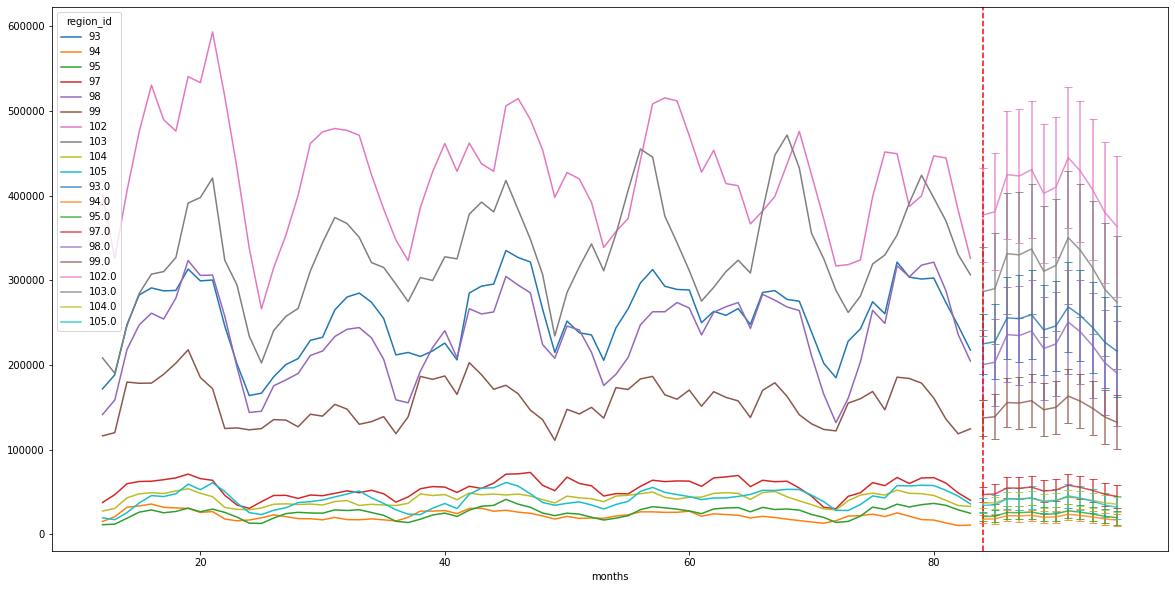

In [81]:
ax = plt.gca()

prod_ns_stacked['avg'].plot(figsize=(20, 10), ax=ax)
ax.axvline(exog_test.index.min(), c='r', linestyle='--')

forecast_all['yerr'] = forecast_all['ci_l'] - forecast_all['prod']
forecast_ns = forecast_all.groupby(['region_id', 'months']).mean()
forecast_ns_stacked = forecast_ns.unstack(level=0)
forecast_ns_stacked.plot(y='prod', figsize=(20, 10), ax=ax, yerr='yerr', 
                         capsize=4, alpha=0.8)

In [82]:
dict_forecasts = forecast_all.groupby(['region_id', 'months'])['prod'].mean().to_dict()

In [83]:
raw_pred_prod['prod'] = raw_pred_prod.apply(lambda x: dict_forecasts[(x['region_id'], x['months'])], axis=1)
nomod_pred_prod['prod'] = raw_pred_prod['prod']
nomod_pred_prod.to_csv('forecast.csv', index=False)